In [ ]:
!pip install roma
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 13.2 MB/s eta 0:00:00


In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable

In [1]:
%matplotlib inline
import numpy as np
import torchvision
import cv2 as cv
import os
import sys
import tqdm
import hack_model
import helper
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import knn_points, knn_gather
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import pytorch3d
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import rasterize_meshes
from pytorch3d.renderer import TexturesUV
import trimesh
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.renderer import (look_at_view_transform,
                                FoVPerspectiveCameras,
                                FoVOrthographicCameras,
                                MeshRenderer,
                                MeshRasterizer,
                                RasterizationSettings,
                                SoftPhongShader,
                                HardPhongShader,
                                SoftGouraudShader,
                                HardGouraudShader,
                                TexturesVertex,
                                PointLights)
import torch
from tqdm.notebook import tqdm
import roma
device = torch.device("cuda")

In [2]:
from texgan import TextureGAN
tex_gan = TextureGAN(model_path="assets/texgan_ffhq_uv.pth", device="cuda")
hack = hack_model.HACK().to(device)
S = hack_model.load_pca(r"model/S.npy").to(device)
E = hack_model.load_pca(r"model/E.npy").to(device)
P = hack_model.load_pca(r"model/P.npy").to(device)



In [3]:
# landmarks
hack_ldms_idx = [1225, 1888, 1052, 367, 1719, 1722, 2199, 1447, 966, 3661, 4390, 3927, 3924, 2608, 3272, 4088, 3443, 268, 493, 1914, 2044, 1401, 3615, 4240, 4114, 2734, 2509, 978, 4527, 4942, 4857, 1140, 2075, 1147, 4269, 3360, 1507, 1542, 1537, 1528, 1518, 1511, 3742, 3751, 3756, 3721, 3725, 3732, 5708, 5695, 2081, 0, 4275, 6200, 6213, 6346, 6461, 5518, 5957, 5841, 5702, 5711, 5533, 6216, 6207, 6470, 5517, 5966]
hack_ldms_idx = torch.tensor(hack_ldms_idx, dtype = torch.long).to(device)
#img_ldms_2d = [[245.38943, 211.26398], [269.57996, 197.60037], [295.4558, 193.82367], [318.24268, 196.51138], [337.3947, 202.87022], [412.22418, 207.54408], [429.6233, 203.0567], [447.1845, 202.6347], [464.03345, 209.03802], [473.92792, 225.38214], [374.25403, 246.31627], [377.7384, 270.30182], [381.5866, 293.22797], [381.53552, 313.69403], [343.51666, 331.29837], [356.35852, 334.01434], [371.46155, 337.51767], [384.52917, 335.69672], [393.01215, 334.25125], [264, 252], [291, 241], [323, 237], [334, 251], [318, 252], [294, 249], [401, 255], [420, 244], [446, 242], [460, 255], [440, 258], [420, 255], [304.49982, 373.8486], [330.85962, 365.56885], [358.05634, 359.96518], [370.289, 363.06686], [381.90784, 361.638], [401.30487, 370.18536], [413.01947, 380.74606], [398.11597, 384.73773], [384.06335, 388.08438], [368.07056, 387.74844], [351.03943, 386.07706], [332.12646, 380.75378], [309.98633, 372.73206], [350.72882, 373.07513], [367.4126, 374.1097], [382.17096, 375.42905], [410.0326, 379.36578], [382.14105, 372.0839], [367.72522, 371.49854], [352.2655, 370.2742]]
#img_ldms_2d = [[176.32904, 257.52527], [178.68747, 299.19366], [184.75555, 337.54608], [191.78381, 371.07678], [205.379, 405.68008], [232.29558, 432.74957], [265.97778, 448.2917], [307.29224, 460.4441], [355.5973, 469.83963], [396.2002, 465.23923], [417.8819, 457.31302], [431.65576, 445.05817], [443.26233, 420.49036], [450.32837, 387.04514], [456.8291, 354.38968], [464.5569, 317.35516], [469.43268, 276.06476], [245.38943, 211.26398], [269.57996, 197.60037], [295.4558, 193.82367], [318.24268, 196.51138], [337.3947, 202.87022], [412.22418, 207.54408], [429.6233, 203.0567], [447.1845, 202.6347], [464.03345, 209.03802], [473.92792, 225.38214], [374.25403, 246.31627], [377.7384, 270.30182], [381.5866, 293.22797], [381.53552, 313.69403], [343.51666, 331.29837], [356.35852, 334.01434], [371.46155, 337.51767], [384.52917, 335.69672], [393.01215, 334.25125], [264, 252], [291, 241], [323, 237], [334, 251], [318, 252], [294, 249], [401, 255], [420, 244], [446, 242], [460, 255], [440, 258], [420, 255], [304.49982, 373.8486], [330.85962, 365.56885], [358.05634, 359.96518], [370.289, 363.06686], [381.90784, 361.638], [401.30487, 370.18536], [413.01947, 380.74606], [398.11597, 384.73773], [384.06335, 388.08438], [368.07056, 387.74844], [351.03943, 386.07706], [332.12646, 380.75378], [309.98633, 372.73206], [350.72882, 373.07513], [367.4126, 374.1097], [382.17096, 375.42905], [410.0326, 379.36578], [382.14105, 372.0839], [367.72522, 371.49854], [352.2655, 370.2742]]
img_ldms_2d_load = [[247.68561, 506.58734], [256.26227, 577.56885], [272.48297, 642.2951], [287.8895, 700.5798], [307.92365, 763.7618], [341.31128, 814.90686], [380.65576, 847.98834], [432.19135, 878.06555], [509.60596, 895.4104], [587.58356, 877.61285], [640.1412, 848.2745], [680.64514, 814.9831], [714.72015, 763.7293], [734.83905, 700.51355], [749.46967, 641.9493], [764.45294, 577.7492], [773.30743, 506.97308], [297.19012, 422.85736], [326.85736, 392.77576], [365.29852, 384.30542], [401.8963, 386.71753], [435.3164, 395.52774], [579.1861, 394.9458], [612.9219, 385.41025], [649.7626, 381.98148], [689.6995, 390.10046], [720.13745, 422.4453], [508.65118, 479.45026], [509.00555, 525.2046], [509.34662, 568.72644], [509.29877, 606.58044], [465.62152, 644.1625], [483.87073, 646.4054], [508.70074, 650.4269], [533.0678, 646.40314], [550.67163, 643.7279], [312.52830188679246, 493.3962264150943], [358.75471698113205, 472.64150943396226], [408.75471698113205, 467.92452830188677], [434.2264150943396, 490.566037735849], [399.3207547169811, 502.8301886792453], [361.58490566037733, 503.77358490566036], [591.7735849056603, 494.33962264150944], [634.2264150943396, 464.1509433962264], [673.8490566037735, 472.64150943396226], [699.3207547169811, 490.566037735849], [665.3584905660377, 504.71698113207543], [633.2830188679245, 501.88679245283015], [415.1724137931035, 740.6896551724138], [453.1034482758621, 719.3103448275863], [485.51724137931035, 706.2068965517242], [506.2068965517241, 713.1034482758621], [526.2068965517242, 705.5172413793103], [554.4827586206897, 722.0689655172414], [598.6206896551724, 739.3103448275863], [566.2068965517242, 755.8620689655172], [539.3103448275863, 774.4827586206897], [506.89655172413796, 777.9310344827586], [478.62068965517244, 775.8620689655172], [448.9655172413793, 760.6896551724138], [427.58620689655174, 740.6896551724138], [469.65517241379314, 736.551724137931], [504.1379310344828, 740.0], [549.6551724137931, 739.3103448275863], [589.6551724137931, 741.3793103448276], [550.3448275862069, 746.8965517241379], [504.82758620689657, 745.5172413793103], [469.65517241379314, 742.7586206896552]]
img_ldms_2d = torch.tensor(img_ldms_2d_load).to(device) / 1024.

In [4]:

img = cv.imread("assets/sample.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_input = cv.resize(img, (512, 512), interpolation = cv.INTER_NEAREST)
img_input = img_input / 255.
img_target = torch.tensor(img_input).to(device)
img_mask = cv.imread("assets/skin.png", 0)
img_mask = cv.resize(img_mask, (512, 512))
img_mask = img_mask / 255.
img_mask = torch.tensor(img_mask).to(device)
m_ = img_mask < 0.5
img_mask[m_] = 0.
img_mask[~m_] = 1.


img_target = img_target.view(-1, 512, 512, 3)
img_mask = img_mask.view(-1, 512, 512, 1)

In [5]:
# flame_mesh, (flame_offset, flame_scale) = normalize_mesh(flame_mesh)
beta = torch.nn.Parameter(torch.randn(1,200).to(device))
theta = torch.nn.Parameter(torch.zeros(1, 8, 3).to(device))
tau = torch.nn.Parameter(torch.zeros(1,1).to(device))
alpha = torch.nn.Parameter(torch.ones(1, 1).to(device))
bsw = torch.nn.Parameter(torch.zeros(1, 55).to(device))
camera = torch.nn.Parameter(torch.tensor([[0,0,0,0.1,1.2,1.9,0.]]).to(device))
lights = torch.nn.Parameter(torch.zeros(1, 9, 3).float().to(device))
tex_code = torch.nn.Parameter(torch.randn(1,tex_gan.G.mapping.num_ws, tex_gan.G.z_dim, device = device))

# optimizer_camera = torch.optim.Adam([theta, camera], lr = 5e-3, weight_decay = 5e-4)
optimizer_camera = torch.optim.AdamW([camera], lr=1e-2, amsgrad=True)
num_camera_optim_iter = 2000


In [6]:
cam_loop = tqdm(range(num_camera_optim_iter))



for _iter in cam_loop:
    optimizer_camera.zero_grad()
    # (B,N,3)
    pred_verts = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"]
    
    rot_vec = camera[:, :3]
    s = camera[:, 3:4]
    t = camera[:, 4:]
    R = roma.rotvec_to_rotmat(rot_vec)
    pred_verts = s*(pred_verts @ R) + t

    pred_verts_2d = pred_verts[..., :2]
    target_ldms_2d = img_ldms_2d.clone()
    target_ldms_2d[:, 1] = 1 - target_ldms_2d[:, 1]

    # ldm
    pred_ldms_2d = torch.index_select(pred_verts_2d[0], 0, hack_ldms_idx)
    loss_ldm = torch.nn.functional.l1_loss(pred_ldms_2d, target_ldms_2d)
    loss = loss_ldm

    cam_loop.set_description(f"[Loss: {loss:.6f}]")
    loss.backward()
    optimizer_camera.step()



  # plot_mesh2(flame_mesh, deformed_mesh, f"{epoch}")


  0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

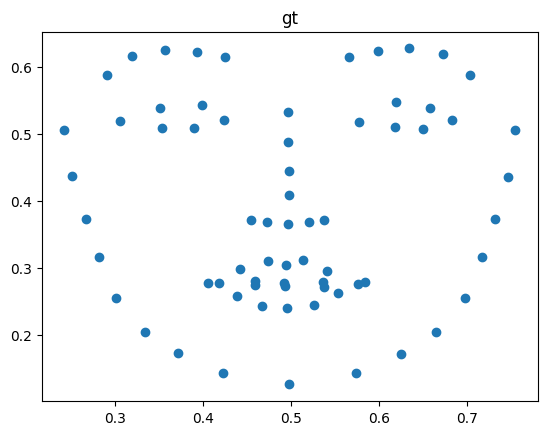

<Figure size 640x480 with 0 Axes>

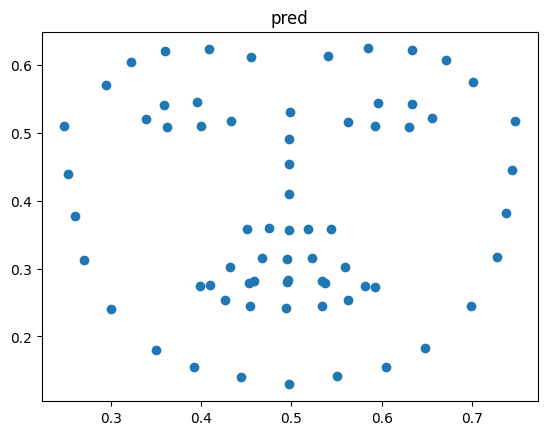

In [7]:
plt.figure(1)
pts_ = img_ldms_2d.clone().cpu().numpy()
x = pts_[:, 0]
y = pts_[:, 1]
plt.figure()
plt.scatter(x, 1-y)
plt.title("gt")
plt.show()

plt.figure(2)
pts_ = pred_ldms_2d.detach().clone().cpu().numpy()
# pts_ = img_ldms_2d.clone().cpu().numpy()
x = pts_[:, 0]
y = pts_[:, 1]
plt.figure()
plt.scatter(x, y)
plt.title("pred")
plt.show()


In [8]:
verts_, o_faces, aux = load_obj("assets/hack_w_HIFI3D_UV.obj")
vts = aux.verts_uvs[None, ...].to(device)  # (N, V, 2)
fvts = o_faces.textures_idx[None, ...].to(device)  # (N, F, 3)
faces = o_faces.verts_idx[None, ...].to(device) # (N,F,3)

In [9]:
class SH:
    def __init__(self):
        self.a = [np.pi, 2 * np.pi / np.sqrt(3.), 2 * np.pi / np.sqrt(8.)]
        self.c = [1 / np.sqrt(4 * np.pi), np.sqrt(3.) / np.sqrt(4 * np.pi), 3 * np.sqrt(5.) / np.sqrt(12 * np.pi)]
        self.init_lit=torch.tensor([0.8, 0, 0, 0, 0, 0, 0, 0, 0]).view(1,1,9).to(device)
sh = SH()
def compute_shading(face_norm, gamma):
    '''
    Compute the shading according the normal vectors and SH lighting coefficients.

    Args:
        face_norm: torch.Tensor, (B, N, 3). The normal vector for each vertex.
        gamma: torch.Tensor, (B, 27). The SH lighting coefficients (R,G,B channels).
    Returns:
        face_shading: torch.Tensor, (B, N, 3). The shading for each vertex.
    '''
    batch_size = gamma.shape[0]
    a, c = sh.a, sh.c
    gamma = gamma.reshape([batch_size, 3, 9])
    gamma = gamma + sh.init_lit.detach()
    gamma = gamma.permute(0, 2, 1)
    Y = torch.cat([
        a[0] * c[0] * torch.ones_like(face_norm[..., :1]).to(device), -a[1] * c[1] * face_norm[..., 1:2],
        a[1] * c[1] * face_norm[..., 2:], -a[1] * c[1] * face_norm[..., :1],
        a[2] * c[2] * face_norm[..., :1] * face_norm[..., 1:2],
        -a[2] * c[2] * face_norm[..., 1:2] * face_norm[..., 2:], 0.5 * a[2] * c[2] / np.sqrt(3.) *
        (3 * face_norm[..., 2:]**2 - 1), -a[2] * c[2] * face_norm[..., :1] * face_norm[..., 2:], 0.5 * a[2] * c[2] *
        (face_norm[..., :1]**2 - face_norm[..., 1:2]**2)
    ],
                  dim=-1)
    r = Y @ gamma[..., :1]
    g = Y @ gamma[..., 1:2]
    b = Y @ gamma[..., 2:]
    face_shading = torch.cat([r, g, b], dim=-1)
    return face_shading
def render_mesh(mesh, uv_vertices, uv_faces, uv_image, light, image_size = 256):
    # vertices (B, V, 3)
    # faces (B, F, 3)

    vertices = mesh.verts_padded()
    faces = mesh.faces_padded()
    normals = mesh.verts_normals_padded().detach()
    shade_pre = compute_shading(normals, light)
    fixed_vertices = vertices.clone()
    fixed_vertices[..., 0] = -2*fixed_vertices[..., 0] + 1
    fixed_vertices[..., 1] = 2*fixed_vertices[..., 1] - 1
    fixed_vertices[..., 2] = fixed_vertices[..., 2] - fixed_vertices[..., 2].min().detach()
    fixed_vertices[..., 2] = -fixed_vertices[..., 2] + 10

    meshes_screen = Meshes(verts=fixed_vertices, faces=faces)
    pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
      meshes_screen,
      image_size=image_size,
      blur_radius=0,
      faces_per_pixel=1,
      bin_size=None,
      max_faces_per_bin=None
    )

    vismask = (pix_to_face > -1).float()
    mask = pix_to_face == -1
    # pix_to_face: (N, image_size, image_size, 1)
    pix_to_face = pix_to_face.clone()
    pix_to_face[mask] = 0
    # torch.Size([262144, 3])
    idx = pix_to_face.flatten()

    pixel_face_idx = torch.index_select(faces.view(-1,3),0, idx) #(n, 3)
    uv_face_idx = torch.index_select(uv_faces.view(-1,3), 0, idx)

    # uv coordinatex
    p1 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 0]) #(n,2)
    p2 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 1]) #(n,2)
    p3 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 2]) #(n,2)

    # shade
    
    s1 = torch.index_select(shade_pre[0], 0, pixel_face_idx[:, 0]) #(n,3)
    s2 = torch.index_select(shade_pre[0], 0, pixel_face_idx[:, 1]) #(n,3)
    s3 = torch.index_select(shade_pre[0], 0, pixel_face_idx[:, 2]) #(n,3)

    p = torch.stack([p1, p2, p3], dim = 1)
    s = torch.stack([s1, s2, s3], dim = 1)

    p_interp = (p * bary_coords.view(-1,3,1)).sum(1) # (n, 2)
    s_interp = (s * bary_coords.view(-1,3,1)).sum(1).view(-1, image_size, image_size, 3).permute(0,3,1,2)

    grid = p_interp.view(-1, image_size, image_size, 2)
    grid = grid * 2 - 1
    grid[...,1] = -grid[..., 1]

    output = torch.nn.functional.grid_sample(uv_image,
                                           grid,
                                           mode='bilinear',
                                           padding_mode="border",
                                           align_corners=False)
    # output (n, c, h ,w)
    #shade = compute_shading(n_interp.view(1,-1,3), light).view(-1, image_size, image_size, 3).permute(0,3,1,2)
    s_interp = torch.clamp(s_interp, min=0)
    #shade = add_SHlight(n_interp, light)
    return torch.clamp((output * s_interp), max=1).permute(0, 2, 3, 1), vismask


  0%|          | 0/4001 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


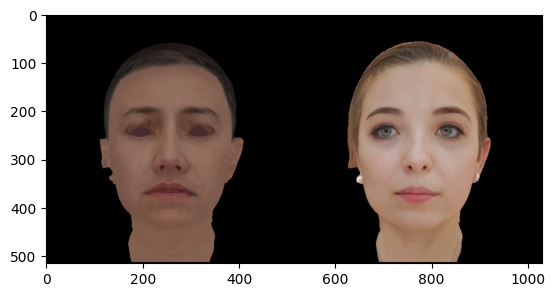

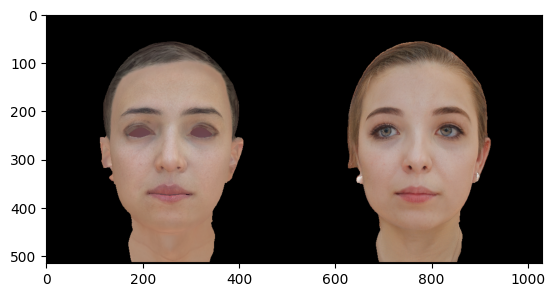

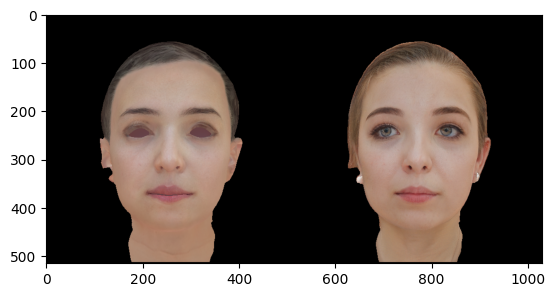

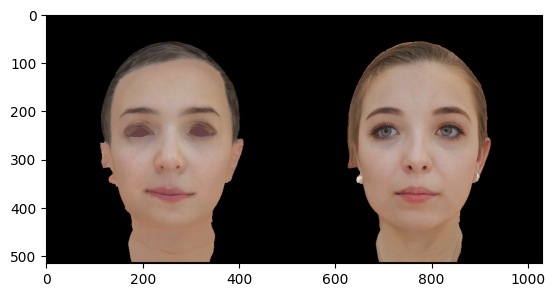

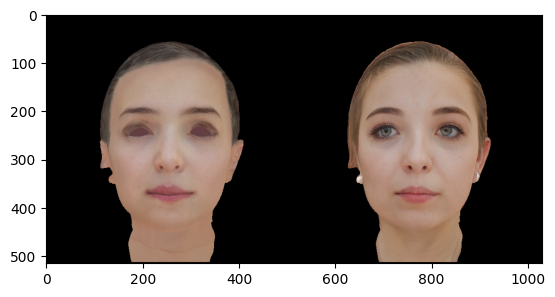

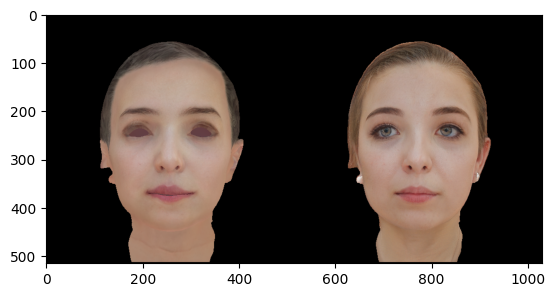

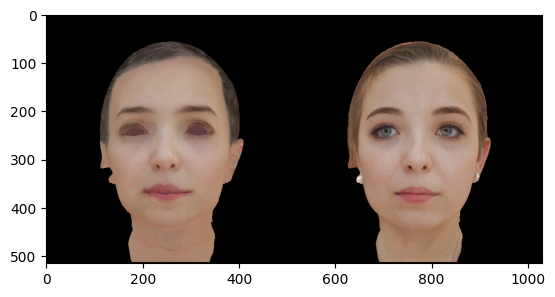

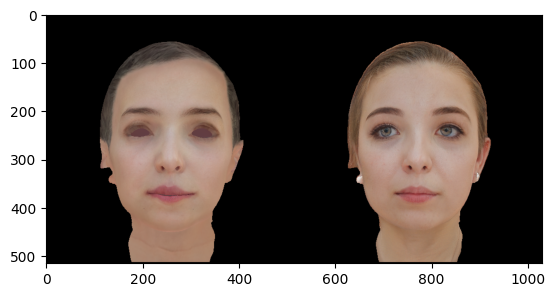

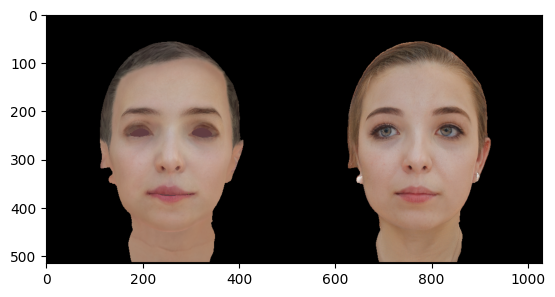

In [10]:
# optimizer_photo = torch.optim.AdamW([beta, theta, tau, bsw,alpha, camera, lights, tex_code], lr=5e-2, amsgrad=True)
# flame_mesh, (flame_offset, flame_scale) = normalize_mesh(flame_mesh)

optimizer_photo = torch.optim.AdamW([
             {'params': [beta, tex_code, alpha,theta, tau, lights], "lr": 1e-2},
             {'params': [camera], 'lr': 1e-4},
             {'params': [bsw], 'lr': 5e-3},
        ],
        
         # lr=1e-4,
         amsgrad=True
 )

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_photo, milestones=[3000,5000,7000], gamma=0.3, last_epoch=-1)

def eye_dis(landmarks):
    # left eye:  [38,42], [39,41] - 1
    # right eye: [44,48], [45,47] -1
    eye_up = landmarks[[37, 38, 43, 44], :]
    eye_bottom = landmarks[[41, 40, 47, 46], :]
    dis = torch.norm(eye_up - eye_bottom, dim = 1) 
    return dis

def eyed_loss(predicted_landmarks, landmarks_gt):
    pred_eyed = eye_dis(predicted_landmarks)
    gt_eyed = eye_dis(landmarks_gt)
    loss = (pred_eyed - gt_eyed).abs().mean()
    return loss

def lip_dis(landmarks):
    # up inner lip:  [62, 63, 64] - 1
    # down innder lip: [68, 67, 66] -1
    lip_up = landmarks[[61, 62, 63], :]
    lip_down = landmarks[[67, 66, 65], :]
    dis = torch.norm(lip_up - lip_down, dim = 1) 
    return dis

def lipd_loss(predicted_landmarks, landmarks_gt):
    pred_lipd = lip_dis(predicted_landmarks)
    gt_lipd = lip_dis(landmarks_gt)
    loss = (pred_lipd - gt_lipd).abs().mean()
    return loss

#optimizer_photo = torch.optim.Adam([beta, theta, tau, bsw, camera, lights, tex_code], lr=1e-4)
num_photo_optim_iter  = 4001
photo_loop = tqdm(range(num_photo_optim_iter))
# optimize photo with render

ldm_weight = torch.ones((68,)).to(device)
ldm_weight[5:7] = 2
ldm_weight[10:12] = 2
# nose points
ldm_weight[27:36] = 1.5
ldm_weight[30] = 6
ldm_weight[31] = 6
ldm_weight[35] = 6
# inner mouth
ldm_weight[60:68] = 1.5
ldm_weight[48:60] = 1.5
ldm_weight[48] = 3
ldm_weight[54] = 3
def latents_geocross_loss(latents):
    '''Uses geodesic distance on sphere to sum pairwise distances of the 18 vectors'''
    if (latents.shape[1] == 1):
        return 0
    else:
        X = latents.view(-1, 1, 18, 512)
        Y = latents.view(-1, 18, 1, 512)
        A = ((X - Y).pow(2).sum(-1) + 1e-9).sqrt()
        B = ((X + Y).pow(2).sum(-1) + 1e-9).sqrt()
        D = 2 * torch.atan2(A, B)
        D = ((D.pow(2) * 512).mean((1, 2)) / 8.).sum()
        return D

for _iter in photo_loop:
    optimizer_photo.zero_grad()
    pred_verts = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"]
    
    rot_vec = camera[:, :3]
    s = camera[:, 3:4]
    t = camera[:, 4:]
    R = roma.rotvec_to_rotmat(rot_vec)
    pred_verts = s*(pred_verts @ R) + t

    # to image space
    pred_verts_2d = pred_verts[..., :2]
    target_ldms_2d = img_ldms_2d.clone()
    target_ldms_2d[:, 1] = 1 - target_ldms_2d[:, 1]

    # ldm
    pred_ldms_2d = torch.index_select(pred_verts_2d[0], 0, hack_ldms_idx)


    # render
    
    latents_w_opt = tex_gan.map_z_to_w(tex_code)
    pred_uv_map = tex_gan.synth_uv_map(latents_w_opt)

    mesh = Meshes(verts = pred_verts, faces = faces)
    rendered_image, vismask = render_mesh(mesh, vts, fvts,pred_uv_map, lights, image_size=512)
    loss_ldm = (torch.norm(pred_ldms_2d - target_ldms_2d, dim = 1, p = 1) * ldm_weight).mean() # ldm_weight
    p_mask =  img_mask.detach()
    loss_photo = (p_mask * (rendered_image - img_target).abs()).sum() / p_mask.sum()
    gamma = lights.reshape([-1, 3, 9])
    gamma_mean = torch.mean(gamma, dim=1, keepdims=True)
    loss_reg_gamma = torch.mean((gamma - gamma_mean) ** 2)
    loss_regularization = torch.norm(beta,2) * 1e-6 + torch.norm(bsw, 2) * 1e-6 + loss_reg_gamma
    loss_nose = (rendered_image[:, 300:300+31, 224:224+62] - img_target[:, 300:300+31, 224:224+62]).abs().mean()
    loss_eye = 10 * eyed_loss(pred_ldms_2d, target_ldms_2d)
    loss_lip = lipd_loss(pred_ldms_2d, target_ldms_2d)

    loss = loss_nose + loss_ldm + loss_eye + loss_lip + loss_photo  + loss_regularization
    loss += latents_geocross_loss(latents_w_opt) * 0.05 
    photo_loop.set_description(f"[Loss: {loss:.6f}] [ldm: {loss_ldm:.6f}] [photo: {loss_photo:.6f}]")

    loss.backward()
    optimizer_photo.step()
    #scheduler.step()
    if _iter % 500 == 0:
        image2show = torch.cat([rendered_image * p_mask.detach(), img_target * p_mask.detach()], dim = 0).permute(0,3,1,2)
        
        image2show = torchvision.utils.make_grid(image2show).detach().cpu()
        image2show = torchvision.transforms.functional.to_pil_image(image2show)
        
        #torchvision.utils.save_image(img, "out.png") 
        plt.imshow(image2show)
        plt.show()




In [12]:
#torchvision.utils.save_image(img, "out.png")
pytorch3d.io.save_obj("assets/result.obj",
                      verts=pred_verts[0],
                      faces = faces[0],
                      verts_uvs = vts[0],
                      faces_uvs = faces[0],
                      texture_map = torch.clamp(pred_uv_map, min=0, max = 1).permute(0,2,3,1)[0])